In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from imblearn.over_sampling import SMOTE
from itertools import combinations
from itertools import product
from sklearn.metrics import mean_squared_error

In [307]:
data = pd.read_csv('TedTalksNewFeatures.csv', encoding='latin1')
data.head()

,Unnamed: 0,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,...,is_TEDNYC,is_culture,is_technology,is_science,is_business,is_globalIssues,is_entertainment,is_design,is_psychology,is_brain
0,0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,...,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,...,0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
2,2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,...,0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,...,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,...,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [308]:
data = data.drop('main_speaker', axis = 1)
data = data.drop('title', axis=1)

In [309]:
data = data.drop('Unnamed: 0', axis=1)
data = data.drop('ratings', axis=1)
data = data.drop('related_talks', axis=1)
data = data.drop('name', axis = 1)

In [310]:
data = data.drop('tags', axis = 1)
data = data.drop('description', axis = 1)
data = data.drop('event_class', axis = 1)

In [311]:
data = data.drop('event', axis =1)

In [312]:
def get_ranking(views):
    if views > 10000000: return 'rank1'
    elif 5000000 < views <= 10000000: return 'rank2'
    elif 1000000 < views <= 5000000: return 'rank3'
    else: return 'rank4'
    
data['rank'] = data['views'].apply(get_ranking)

In [313]:
data.dtypes

comments                    int64
duration                    int64
film_date                   int64
languages                   int64
num_speaker                 int64
published_date              int64
views                       int64
titleLength                 int64
numTags                     int64
descLength                  int64
Funny                       int64
Beautiful                   int64
Ingenious                   int64
Courageous                  int64
Longwinded                  int64
Confusing                   int64
Informative                 int64
Fascinating                 int64
Unconvincing                int64
Persuasive                  int64
Jaw-dropping                int64
OK                          int64
Obnoxious                   int64
Inspiring                   int64
Positive                    int64
Moderate                    int64
Negative                    int64
is_yearlyTedConference      int64
is_TEDGlobal                int64
is_TEDSalon   

In [314]:
y = data['views']
X = data.drop('views', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Check Levels of Views in the dataset

In [315]:
X_train['rank'].value_counts()

rank3    1140
rank4     822
rank2      50
rank1      28
Name: rank, dtype: int64

In [316]:
X_test['rank'].value_counts()

rank3    264
rank4    225
rank2     15
rank1      6
Name: rank, dtype: int64

In [317]:
rank3_train, rank4_train, rank2_train, rank1_train = X_train['rank'].value_counts()
rank3_test, rank4_test, rank2_test, rank1_test = X_test['rank'].value_counts()

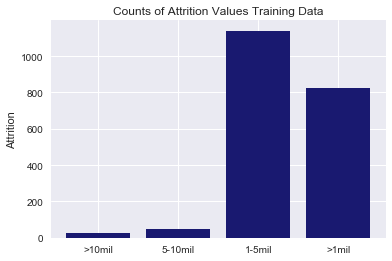

In [318]:
x = np.arange(4)
tr_vals = [rank1_train, rank2_train, rank3_train, rank4_train] #1 is the biggest, 4 is the smallest views
test_vals = [rank1_test, rank2_test, rank3_test, rank4_test]

plt.bar(x, tr_vals,color = 'midnightblue');
plt.xticks(x, ('>10mil', '5-10mil', '1-5mil', '>1mil'));
plt.ylabel('Attrition');
plt.title('Counts of Attrition Values Training Data');

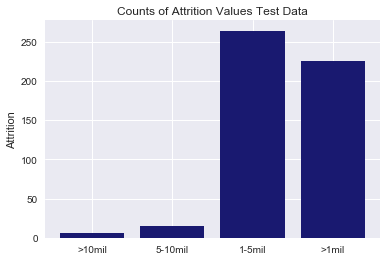

In [319]:
plt.bar(x, test_vals,color = 'midnightblue');
plt.xticks(x, ('>10mil', '5-10mil', '1-5mil', '>1mil'));
plt.ylabel('Attrition');
plt.title('Counts of Attrition Values Test Data');

### Balance Groups of Views in the Dataset

In [320]:
y = data['rank']
X = data.drop('rank', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [321]:
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [322]:
features_names = X_train.columns.values
X_train_res_df = pd.DataFrame(X_train_res)
X_train_res_df.columns = np.ndarray.tolist(features_names)

In [323]:
X_train_res_df.head()

,comments,duration,film_date,languages,num_speaker,published_date,views,titleLength,numTags,descLength,...,is_TEDNYC,is_culture,is_technology,is_science,is_business,is_globalIssues,is_entertainment,is_design,is_psychology,is_brain
0,124.0,1016.0,1.379635e+09,26.0,1.0,1.381764e+09,1041732.0,17.0,4.0,280.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,168.0,684.0,1.330474e+09,40.0,1.0,1.333984e+09,3055565.0,22.0,5.0,206.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,202.0,1112.0,1.340669e+09,24.0,1.0,1.348585e+09,1245095.0,52.0,10.0,330.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15.0,467.0,1.481587e+09,16.0,1.0,1.500649e+09,1026708.0,28.0,6.0,327.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,59.0,915.0,1.455581e+09,29.0,1.0,1.466694e+09,4235594.0,46.0,9.0,455.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [324]:
rank1 = np.count_nonzero(y_train_res =='rank1')
rank2 = np.count_nonzero(y_train_res =='rank2')
rank3 = np.count_nonzero(y_train_res=='rank3')
rank4 = np.count_nonzero(y_train_res=='rank4')

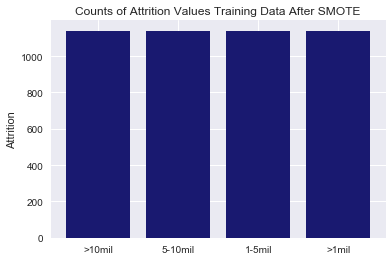

In [325]:
x = np.arange(4)
tr_vals = [rank1, rank2, rank3, rank4] #1 is the biggest, 4 is the smallest views

plt.bar(x, tr_vals,color = 'midnightblue');
plt.xticks(x, ('>10mil', '5-10mil', '1-5mil', '>1mil'));
plt.ylabel('Attrition');
plt.title('Counts of Attrition Values Training Data After SMOTE');

In [326]:
#save as a csv
np.savetxt('SMOTE_dataset.csv', X_train_res_df, delimiter=",")
np.savetxt('SMOTE_test_data.csv', X_test, delimiter=',')

## Back to Random Forest

In [327]:
y_train = X_train_res_df['views']
X_train = X_train_res_df.drop('views', axis=1)
y_test = X_test['views']
X_test = X_test.drop('views', axis=1)

There is now a problem with using gridsearch- when we do k-fold cross validation we need to have the training sets be oversampled and the validation sets not be oversampled- with gridsearch we have all folds that are oversampled...

### Cross Validation for the RF Parameters

In [328]:
y = data['rank']
X = data.drop('rank', axis=1)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.2, random_state=42)
#piece together X_train and y_train to one training set, then use this for the CV
y_train_cv = y_train_cv.to_frame()
CV_data = pd.merge(X_train_cv, y_train_cv, left_index=True, right_index=True, how = 'left')

In [329]:
indices = [1,2,3,4,5]
dfList = np.array_split(CV_data, 5)
CVgrid = []
n_estimators = [100, 200]; max_depth = [10,13,15,17]
c = list(product(n_estimators, max_depth))

for choices in c:
    for combo in combinations(indices, 4):
        #append and then oversample
        comb_folds = pd.concat([dfList[combo[0]-1], dfList[combo[1]-1], 
                                dfList[combo[2]-1], dfList[combo[3]-1]])
        remain_ind = 15 - sum(combo) #isolate the remaining index 
        remain = dfList[remain_ind-1].drop('rank', axis=1)
        
        #oversample the comb_folds
        y = comb_folds['rank']
        X = comb_folds.drop('rank', axis = 1)
        sm = SMOTE(random_state=0)
        X_res, y_res = sm.fit_sample(X, y)
        features_names = X.columns.values
        X_res_df = pd.DataFrame(X_res)
        X_res_df.columns = np.ndarray.tolist(features_names)

        #split into the correct X and y
        y_train_correct = X_res_df['views']
        X_train_correct = X_res_df.drop('views', axis=1)
        y_test_correct = remain['views']
        X_test_correct = remain.drop('views', axis=1)
    
        mse = []
        #choices[0] is the n_estimators, choices[1] is max_depth
        regr = RandomForestRegressor(n_estimators=choices[0], max_depth=choices[1], random_state=42)
        regr.fit(X_train_correct, y_train_correct)
        y_pred = regr.predict(X_test_correct)
        MSE = mean_squared_error(y_test_correct, y_pred)
        mse.append(MSE)
      
    mse_info = {}
    avg_mse = sum(mse)/len(mse)
    mse_info['MSE'] = avg_mse
    mse_info['N_trees'] = choices[0]
    mse_info['Max_depth'] = choices[1]
    print('model with %s trees and %s depth has MSE of %s' %(choices[0], choices[1], avg_mse))
    CVgrid.append(mse_info)

model with 100 trees and 10 depth has MSE of 2103055549504.67
model with 100 trees and 13 depth has MSE of 2026372591350.8909
model with 100 trees and 15 depth has MSE of 2026185208225.7378
model with 100 trees and 17 depth has MSE of 2032061677711.7358
model with 200 trees and 10 depth has MSE of 2084641181633.796
model with 200 trees and 13 depth has MSE of 1994025083341.7046
model with 200 trees and 15 depth has MSE of 1973224618186.7786
model with 200 trees and 17 depth has MSE of 1985837221584.4482


In [330]:
#make into a dataframe and get the best parameters
#need to make it a list of dictionaries instead
CVgrid

[{'MSE': 2103055549504.67, 'Max_depth': 10, 'N_trees': 100},
 {'MSE': 2026372591350.8909, 'Max_depth': 13, 'N_trees': 100},
 {'MSE': 2026185208225.7378, 'Max_depth': 15, 'N_trees': 100},
 {'MSE': 2032061677711.7358, 'Max_depth': 17, 'N_trees': 100},
 {'MSE': 2084641181633.796, 'Max_depth': 10, 'N_trees': 200},
 {'MSE': 1994025083341.7046, 'Max_depth': 13, 'N_trees': 200},
 {'MSE': 1973224618186.7786, 'Max_depth': 15, 'N_trees': 200},
 {'MSE': 1985837221584.4482, 'Max_depth': 17, 'N_trees': 200}]

In [331]:
CVresults = pd.DataFrame(CVgrid)
CVresults.head()

,MSE,Max_depth,N_trees
0,2.103056e+12,10,100
1,2.026373e+12,13,100
2,2.026185e+12,15,100
3,2.032062e+12,17,100
4,2.084641e+12,10,200


In [332]:
#find the minimum MSE
CVresults.loc[CVresults['MSE'] == CVresults['MSE'].min()]

,MSE,Max_depth,N_trees
6,1.973225e+12,15,200


In [286]:
regr = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [287]:
X_train.shape

(4560, 42)

In [288]:
X_test.shape

(510, 42)

In [289]:
y_test.shape

(510,)

42


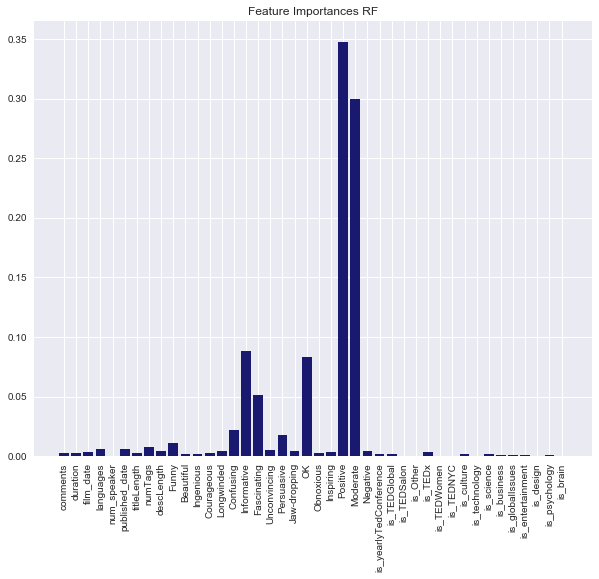

In [304]:
labels = X_train.columns
x_axis = np.arange(42)
impo = regr.feature_importances_


plt.figure(figsize = (10,8))
plt.bar(x_axis, impo, align='center', color='midnightblue');
plt.xticks(x_axis, labels, rotation='vertical');
plt.title('Feature Importances RF');
print(regr.n_features_)

In [293]:
y_pred = regr.predict(X_test)
mse_random_forest_all = mean_squared_error(y_test, y_pred)

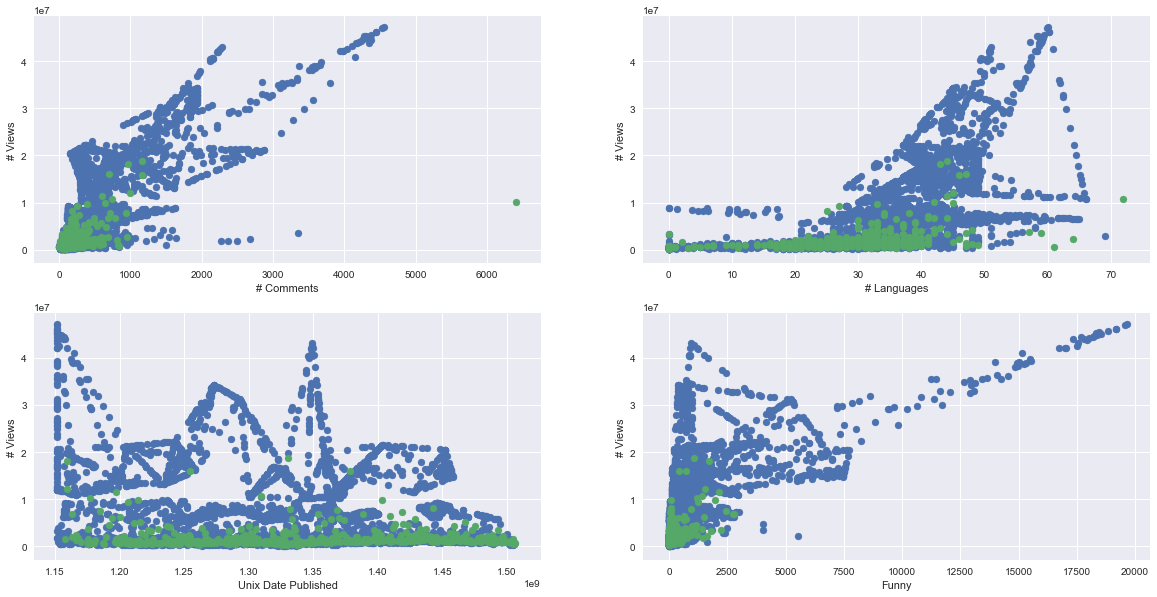

In [294]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.scatter(X_train['comments'], y_train);
plt.scatter(X_test['comments'], y_pred);
plt.xlabel('# Comments');
plt.ylabel('# Views');

plt.subplot(2, 2, 2)
plt.scatter(X_train['languages'], y_train);
plt.scatter(X_test['languages'], y_pred);
plt.xlabel('# Languages');
plt.ylabel('# Views');

plt.subplot(2, 2, 3)
plt.scatter(X_train['published_date'], y_train);
plt.scatter(X_test['published_date'], y_pred);
plt.xlabel('Unix Date Published');
plt.ylabel('# Views');

plt.subplot(2, 2, 4)
plt.scatter(X_train['Funny'], y_train);
plt.scatter(X_test['Funny'], y_pred);
plt.xlabel('Funny');
plt.ylabel('# Views');

In [295]:
mse_random_forest_all

1015061001720.9581

In [296]:
mse_before_oversample = 2103119145192.1746
mse_old_features_with_oversample = 3538995293458.7183
#taken from previous notebook

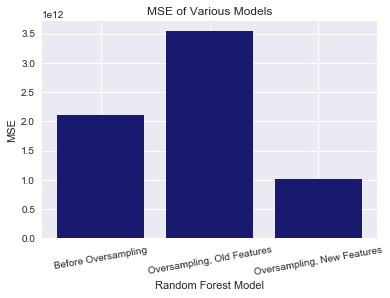

In [302]:
#compare with graph
x_axis = [1,2,3]
MSE = [mse_before_oversample, mse_old_features_with_oversample, mse_random_forest_all]
LABELS = ['Before Oversampling', 'Oversampling, Old Features', 'Oversampling, New Features']

plt.bar(x_axis, MSE, align='center', color = 'midnightblue');
plt.xticks(x_axis, LABELS, rotation=10);
plt.title('MSE of Various Models');
plt.xlabel('Random Forest Model');
plt.ylabel('MSE');